lovely_jax enabled for enhanced array visualization
JAX devices: [CudaDevice(id=0)]
Default backend: gpu
Model initialized with 7 DCM sites per atom
Data keys: ['R', 'D', 'Q', 'Z', 'esp', 'esp_grid', 'F']
ESP grid shape: (1983, 44510)
ESP grid points shape: (1983, 44510, 3)
shape (1983, 18, 3)
D (1983, 3)
Q 3 (1983, 3, 3) 1983
Q (1983, 3, 3)
R (1983, 18, 3)
(1983, 18, 3)
['R', 'Z', 'F', 'esp', 'D', 'esp_grid', 'Q']
1983
0 R 1983 (1983, 18, 3)
1 Z 1983 (1983, 18)
2 F 1983 (1983, 18, 3)
3 esp 1983 (1983, 44510)
4 D 5949 (5949, 1)
5 esp_grid 1983 (1983, 44510, 3)
6 Q 1983 (1983, 3, 3)
Training ESP shape: (1200, 44510)
Validation ESP shape: (100, 44510)


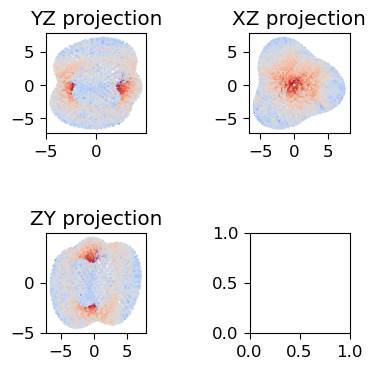

In [1]:
"""
DCMNet Training Example
=======================

This example demonstrates how to train a DCMNet model for predicting molecular 
electrostatic potential (ESP) using distributed charge multipoles (DCM).

The workflow includes:
1. Environment setup and configuration
2. Model initialization
3. Data preparation
4. Model training
5. Results analysis and visualization
"""

# %% [markdown]
# # DCMNet Training Example
#
# This notebook shows how to train a message-passing neural network to predict
# molecular electrostatic potentials using distributed charge multipole (DCM) 
# representations.

# %% [markdown]
# ## Setup and Imports

# %%
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import patchworklib as pw
import ase
from ase.visualize import view
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

# Configure JAX to use 95% of GPU memory
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Verify JAX setup
print("JAX devices:", jax.devices())
print("Default backend:", jax.default_backend())

# Initialize random key for reproducibility
key = jax.random.PRNGKey(0)

# %% [markdown]
# ## Model Configuration

# %%
# Number of distributed charge multipoles per atom
NDCM = 7

# Initialize the message-passing model
model = MessagePassingModel(
    features=32,                  # Hidden layer dimension
    max_degree=2,                 # Maximum spherical harmonic degree
    num_iterations=2,             # Number of message-passing iterations
    num_basis_functions=32,       # Radial basis functions for distance encoding
    cutoff=4.0,                   # Interaction cutoff in Angstroms
    n_dcm=NDCM,                   # Number of DCM sites per atom
    include_pseudotensors=False,  # Whether to include pseudotensor features
)

print(f"Model initialized with {NDCM} DCM sites per atom")

# %% [markdown]
# ## Data Loading and Preparation

# %%
# Load molecular data from NPZ file
data_path = Path('/home/ericb/testmmml/test.npz')
data_loaded = np.load(data_path, allow_pickle=True)

print("Data keys:", list(data_loaded.keys()))
print("ESP grid shape:", data_loaded["esp"].shape)
print("ESP grid points shape:", data_loaded["esp_grid"].shape)

# %% [markdown]
# ### Visualize ESP Data
# 
# View the electrostatic potential from different projections

# %%
from patchworklib import Brick

ESP_VRANGE = 4  # Color scale range for visualization

# Create 2D projections of the 3D ESP grid
fig_yz = Brick()
fig_yz.scatter(
    data_loaded["esp_grid"][0][:, 1], 
    data_loaded["esp_grid"][0][:, 2], 
    s=0.1, c=data_loaded["esp"][0], 
    cmap="coolwarm", vmin=-ESP_VRANGE, vmax=ESP_VRANGE
)
fig_yz.set_title("YZ projection")

fig_xz = Brick()
fig_xz.scatter(
    data_loaded["esp_grid"][0][:, 0], 
    data_loaded["esp_grid"][0][:, 2], 
    s=0.1, c=data_loaded["esp"][0], 
    cmap="coolwarm", vmin=-ESP_VRANGE, vmax=ESP_VRANGE
)
fig_xz.set_title("XZ projection")

fig_zy = Brick()
fig_zy.scatter(
    data_loaded["esp_grid"][0][:, 2], 
    data_loaded["esp_grid"][0][:, 1], 
    s=0.1, c=data_loaded["esp"][0], 
    cmap="coolwarm", vmin=-ESP_VRANGE, vmax=ESP_VRANGE
)
fig_zy.set_title("ZY projection")

# Display combined visualization
(fig_yz | fig_xz) / (fig_zy | Brick())

# %% [markdown]
# ### Prepare Training and Validation Datasets

# %%
train_data, valid_data = prepare_datasets(
    key, 
    num_train=1200,              # Number of training samples
    num_valid=100,               # Number of validation samples
    filename=[data_path],        # Path to data file
    clean=False,                 # Whether to clean outliers
    esp_mask=False,              # Whether to mask ESP values
    natoms=18,                   # Number of atoms in molecules
)

print(f"Training ESP shape: {train_data['esp'].shape}")
print(f"Validation ESP shape: {valid_data['esp'].shape}")

# %% [markdown]
# ## Model Training
#
# Train the model in two stages:
# 1. Initial training with higher learning rate
# 2. Fine-tuning with lower learning rate


In [2]:

# %% [markdown]
# ### Stage 1: Initial Training

# %%
params, valid_loss = train_model(
    key=key, 
    model=model,
    writer=None,                 # TensorBoard writer (optional)
    train_data=train_data, 
    valid_data=valid_data,
    num_epochs=30,               # Number of training epochs
    learning_rate=1e-3,          # Initial learning rate
    batch_size=1,                # Batch size
    ndcm=model.n_dcm,            # Number of DCM sites
    esp_w=10000.0,               # Weight for ESP loss term
)

print(f"Stage 1 validation loss: {valid_loss:.6f}")

# %% [markdown]
# ### Stage 2: Fine-tuning

# %%
params, valid_loss = train_model(
    key=key, 
    model=model,
    writer=None,
    train_data=train_data, 
    valid_data=valid_data,
    num_epochs=100,              # Extended training
    learning_rate=5e-4,          # Reduced learning rate
    batch_size=1,
    ndcm=model.n_dcm,
    esp_w=1000.0,                # Reduced ESP weight
    restart_params=params,       # Continue from stage 1
)


Preparing batches
..................
Training
..................


KeyError: 'vdw_surface'

In [ ]:

print(f"Stage 2 validation loss: {valid_loss:.6f}")

# %% [markdown]
# ## Model Analysis and Visualization

# %% [markdown]
# ### Prepare Test Batch

# %%
# Load a test molecule for analysis
batch = prepare_batch(data_path, index=0)
batch['com'] = np.mean(batch['R'].T, axis=-1)  # Center of mass
batch["Dxyz"] = batch["R"] - batch["com"]      # Coordinates relative to COM

# Run model prediction
output = dcmnet_analysis(params, model, batch)

print(f"RMSE (all points): {output['rmse_model']:.6f}")
print(f"RMSE (masked): {output['rmse_model_masked']:.6f}")

# %% [markdown]
# ### Visualize Molecular Structure

# %%
# Create ASE atoms object for visualization
n_atoms = int(batch["N"])
atoms = ase.Atoms(
    batch["Z"][:n_atoms],  # Atomic numbers
    batch["R"][:n_atoms]   # Atomic positions
)
view(atoms, viewer="x3d")

# %% [markdown]
# ### ESP Prediction Quality

# %%
VMAX = 0.01  # Color scale for ESP visualization
N_SURFACE_POINTS = 4150

# Correlation plot: predicted vs. true ESP
correlation_ax = pw.Brick()
correlation_ax.scatter(batch["esp"], output['esp_pred'], s=1, alpha=0.5)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
correlation_ax.plot(
    np.linspace(-max_val, max_val, 100), 
    np.linspace(-max_val, max_val, 100), 
    'r--', linewidth=2
)
correlation_ax.set_aspect('equal')
correlation_ax.set_xlabel('True ESP')
correlation_ax.set_ylabel('Predicted ESP')
correlation_ax.set_title('ESP Correlation')

# True ESP on VdW surface
ax_true = pw.Brick()
ax_true.scatter(
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 0], 
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 1], 
    c=batch["esp"][0][:N_SURFACE_POINTS],
    s=0.01, vmin=-VMAX, vmax=VMAX, cmap='coolwarm'
)
ax_true.set_aspect('equal')
ax_true.set_title('True ESP')

# Predicted ESP on VdW surface
ax_pred = pw.Brick()
ax_pred.scatter(
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 0], 
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 1], 
    c=output['esp_pred'][:N_SURFACE_POINTS],
    s=0.01, vmin=-VMAX, vmax=VMAX, cmap='coolwarm'
)
ax_pred.set_aspect('equal')
ax_pred.set_title('Predicted ESP')

# Difference (error) map
ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 0], 
    batch["vdw_surface"][0][:N_SURFACE_POINTS, 1], 
    c=batch["esp"][0][:N_SURFACE_POINTS] - output['esp_pred'][:N_SURFACE_POINTS],
    s=0.01, vmin=-VMAX, vmax=VMAX, cmap='coolwarm'
)
ax_diff.set_aspect('equal')
ax_diff.set_title('Error (True - Pred)')

# Combine all plots
correlation_ax | ax_true | ax_pred | ax_diff

# %% [markdown]
# ### Predicted Charge Distribution

# %%
# Visualize predicted monopole (charge) distribution
charge_ax = pw.Brick()
charge_ax.matshow(
    output["mono"][0][:n_atoms], 
    vmin=-1, vmax=1, cmap='RdBu_r'
)
charge_ax.set_title('Charge Multipoles')
charge_ax.set_xlabel('Multipole index')
charge_ax.set_ylabel('Atom index')

# Sum of charges per atom
sum_charge_ax = pw.Brick()
sum_charge_ax.matshow(
    output["mono"][0][:n_atoms].sum(axis=-1)[:, None],
    vmin=-1, vmax=1, cmap='RdBu_r'
)
sum_charge_ax.axis("off")

# Combine with colorbar
fig_charges = (sum_charge_ax | charge_ax)
fig_charges.add_colorbar(vmin=-1, vmax=1)

# Print total charge
total_charge = output["mono"][0][:n_atoms].sum()
print(f"Total molecular charge: {total_charge:.4f}")

# %% [markdown]
# ### Visualize DCM Sites

# %%
# Extract DCM positions for visualization
dcm_positions = output["dipo"][:n_atoms * NDCM]

# Create pseudo-atoms for DCM sites (using hydrogen)
dcm_z = np.ones(len(dcm_positions), dtype=int)

dcm_atoms = ase.Atoms(dcm_z, dcm_positions)
view(dcm_atoms, viewer="x3d")

print(f"Number of DCM sites: {len(dcm_positions)}")
print(f"DCM sites per atom: {NDCM}")